In [2]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0
0.11.0
cpu


In [3]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

In [4]:
# tacotron2

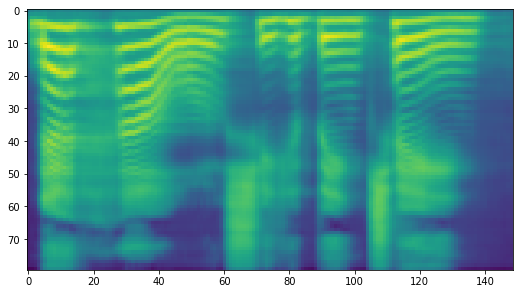

In [5]:
text = "ni hao, wo shi hu bing cheng"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, attention = tacotron2.infer(processed, lengths)


plt.imshow(spec[0].cpu().detach())

Using cache found in /home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'co

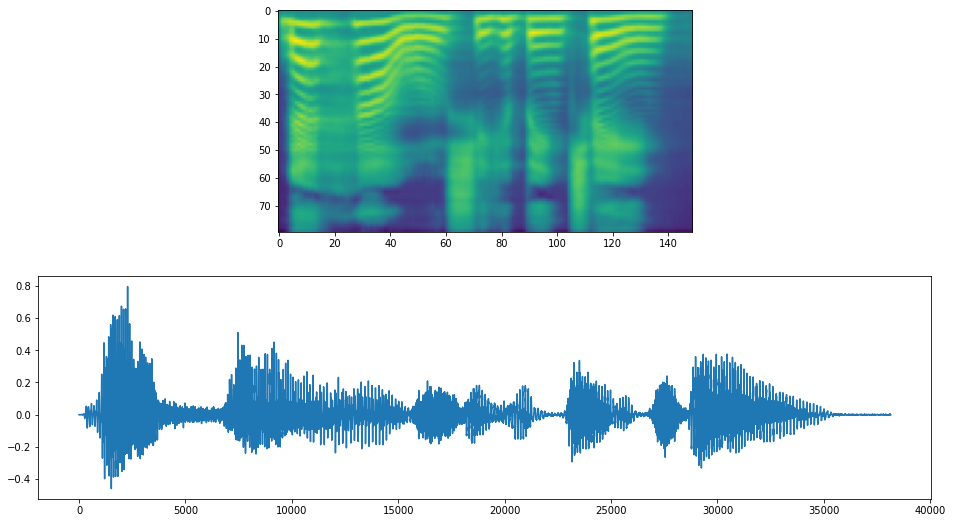

In [6]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach())
ax2.plot(waveforms[0].cpu().detach())

torchaudio.save("_assets/my_output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)

# 初步训练/单说话人少量句子

In [7]:
# %load_ext autoreload
# %autoreload 2

In [8]:
# import utils.dataset
from utils.dataset import AiShell3PersonDataset, MelLoaderGenerator, RawLoaderGenerator

In [9]:
from pypinyin import lazy_pinyin

In [10]:
from torchaudio.pipelines._tts.utils import _get_chars
labels = _get_chars() + ('1', '2', '3', '4', '5')

In [11]:
labels[0]

'_'

In [32]:
def raw_audio_transform(sample, sample_rate=None):
        audio = sample['audio']
        audio = torchaudio.functional.vad(audio, sample_rate, trigger_level=5)
        audio = audio / torch.abs(audio).max()*0.15
        text = sample['text']
        text = text.split(' ')
        pinyin = [text[i] for i in range(len(text)) if i%2==1]
        pinyin = labels[0].join(pinyin)
        chinese = [text[i] for i in range(len(text)) if i%2==0]
        return {'audio':audio,
                'text': pinyin,
                'chinese': chinese}
sample_rate = 16000               
dataset = AiShell3PersonDataset('/scratch/bh2283/data/data_aishell3/train/', transform=raw_audio_transform, \
        person_id='SSB0011', sample_rate=sample_rate)
torchaudio.save('_assets/temp.wav', dataset[0]['audio'], sample_rate)
dataset[0]

{'audio': tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.6321e-05, 4.1846e-05,
          6.0390e-05]]),
 'text': 'yi2_wei4_gang2_gu3_fen1_xi1_shi1_biao3_shi4',
 'chinese': ['一', '位', '港', '股', '分', '析', '师', '表', '示']}

In [33]:
loaderGenerator = RawLoaderGenerator(labels, k_size=5)
loaderGenerator.version

'0.02'

In [72]:
batch_size = 8
train_set, test_set = dataset.split([1,0])
train_loader = loaderGenerator.dataloader(train_set, batch_size=batch_size)
len(train_set), len(test_set)

(460, 0)

测试随机提取几组数据

In [37]:
steps = 3
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    print(sample_batched['audio'].shape, sample_batched['target'].shape)
    steps -= 1

torch.Size([8, 93294]) torch.Size([8, 107])
torch.Size([8, 91805]) torch.Size([8, 99])
torch.Size([8, 78749]) torch.Size([8, 102])


测试sort后是否顺序正常，听一下音频和文字是否相符

In [38]:
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    # sample_batched['audio'][0]
    torchaudio.save('_assets/temp.wav', sample_batched['audio'][0].unsqueeze(0), sample_rate)
    print(loaderGenerator.id2label(sample_batched['target'][0]))
    print(sample_batched['target_len'])
    steps -= 1

zui4_gao1_ren2_min2_fa3_yuan4_jian1_tong1_guo4_yi2_xiang4_you3_guan1_nei4_mu4_jiao1_yu4_de5_si1_fa2_jie3_shi4
tensor([109,  58,  57,  53,  43,  20,  16])


数据绘制mel

In [39]:
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,\
            n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=80, \
                f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")
safe_log = lambda x: torch.log(x+2**(-15))

tensor(0.1500)


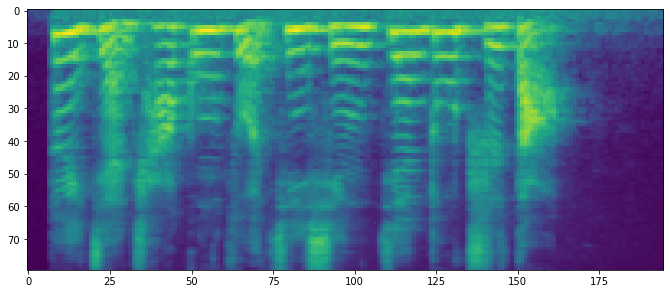

In [42]:
audio_test = dataset[91]['audio'][0]
print(torch.abs(audio_test).max())
# audio_test = audio_test / torch.abs(audio_test).max()*0.15
# audio_test = torchaudio.functional.vad(audio_test, sample_rate, trigger_level=5)
mel_test = safe_log(mel_transform(audio_test))
plt.imshow(mel_test)

In [21]:
my_tacotron2 = bundle.get_tacotron2()

In [22]:
from torch.nn.utils.rnn import pad_sequence

In [23]:
new_embedding = torch.nn.Embedding(len(labels), tacotron2.embedding.embedding_dim)

In [24]:
new_embedding.weight[:tacotron2.embedding.num_embeddings, :].shape

torch.Size([38, 512])

In [25]:
tacotron2.embedding.weight.shape

torch.Size([38, 512])

In [26]:
new_embedding.weight[:tacotron2.embedding.num_embeddings, :].data=tacotron2.embedding.weight.data

In [27]:
my_tacotron2.embedding=new_embedding

测试跑一个数据

In [66]:
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    steps -= 1
    print('audio', sample_batched['audio'].shape, 'target', sample_batched['target'].shape)
    audio = sample_batched['audio']
    tokens = sample_batched['target']
    audio_len = sample_batched['audio_len']
    tokens_len = sample_batched['target_len']
    # print(tokens.shape)
    # print(audio[1][:audio_len[1]].shape)
    # break
    mels_list = [safe_log(mel_transform(audio[i][:audio_len[i]])).transpose(0,1) for i in range(len(audio_len))]
    print('mel', mels_list[0].shape)
    print('tokens', loaderGenerator.id2label(tokens[0]))
    mel_length = torch.tensor([mel.shape[-2] for mel in mels_list])
    # print('mel_length', mel_length)
    max_audio_length = torch.max(mel_length)
    mels_tensor = pad_sequence(mels_list, batch_first=True, padding_value=torch.log(torch.tensor(2**(-15)))).permute(0,2,1)
    print('mels', mels_tensor.shape)
    org_mel, pos_mel, stop_token, attentions = my_tacotron2.forward(tokens, tokens_len, mels_tensor, mel_length)
    print('output',org_mel.shape, pos_mel.shape, stop_token.shape, attentions.shape)
    true_stop_token = torch.zeros(stop_token.shape)
    for i in range(true_stop_token.shape[0]):
        true_stop_token[i][mel_length[i]:]+=1.0
    show_id = 4
    stop_token = torch.sigmoid(stop_token)
    # print(stop_token[show_id][200:])
    for i in range(len(stop_token[show_id])):
        if stop_token[show_id][i] > 0.5:
            print('stop',i)
            break
    

audio torch.Size([8, 78749]) target torch.Size([8, 102])
mel torch.Size([308, 80])
tokens hen3_kuai4_wo3_jiu4_fa1_xian4_zi4_ji3_yu3_pang2_ren2_bi2_qi3_lai2_shen1_cai2_wan2_quan2_zou3_yang4_le5
mels torch.Size([8, 80, 308])
output torch.Size([8, 80, 308]) torch.Size([8, 80, 308]) torch.Size([8, 308]) torch.Size([8, 308, 102])


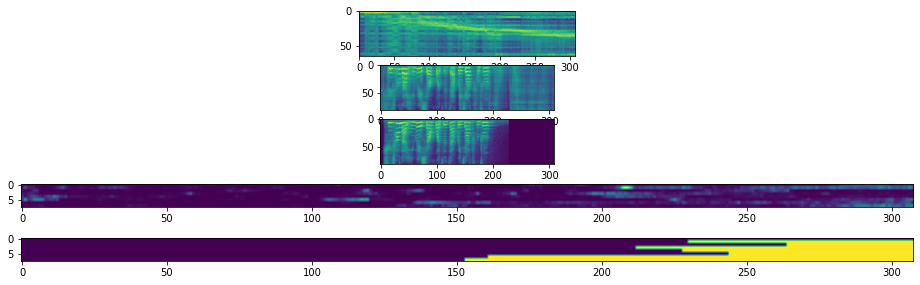

In [71]:
if __name__ =='__main__':
    fig, axs = plt.subplots(5)
    axs[0].imshow(safe_log(attentions[show_id][:, :tokens_len[show_id]]).detach().transpose(0,1).numpy())
    axs[1].imshow(pos_mel[show_id].detach().numpy())
    axs[2].imshow(mels_tensor[show_id].detach().numpy())
    axs[3].imshow(safe_log(stop_token).detach().numpy())
    axs[4].imshow(true_stop_token.detach().numpy())

## 训练

正式训练中我们需要几个loss一起训练
1. org_mel vs true_mel
2. pos_mel vs true_mel
3. sigmoid(stop_token) vs 0 and 1

那么，开始吧

In [73]:
model = my_tacotron2

In [74]:
params = model.parameters()
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
initial_epoch = 0
mse_loss = torch.nn.MSELoss()
mean = lambda x: sum(x)/len(x)

In [75]:
def save_log(file_name, log, mode='a', path = './log/n1-'):
    with open(path+file_name, mode) as f:
        if mode == 'a':
            f.write('\n')
        if type(log) is str:
            f.write(log)
            print(log)
        else:
            log = [str(l) for l in log]
            f.write(' '.join(log))
            print(' '.join(log))

In [79]:
def dump_model(EPOCH, LOSS, PATH):
    torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

def save_temp(EPOCH, LOSS):
    PATH = f"./checkpoint/tacotron2/model_temp.pt"
    dump_model(EPOCH, LOSS, PATH)
    
def save_checkpoint(EPOCH, LOSS):
    PATH = f"./checkpoint/tacotron2/model_{EPOCH}_{'%.3f' % LOSS}.pt"
    dump_model(EPOCH, LOSS, PATH)

In [100]:
def train(epoch=1):
    train_loss_q = []
    test_loss_q = []
    for epoch in range(initial_epoch, epoch):
        
        batch_train_loss = []
        for i_batch, sample_batched in enumerate(train_loader):
            model.train()
            # Step 1. Prepare Data
            audio = sample_batched['audio']
            tokens = sample_batched['target']
            audio_len = sample_batched['audio_len']
            tokens_len = sample_batched['target_len']

            # Step 2. Run our forward pass
            mels_list = [safe_log(mel_transform(audio[i][:audio_len[i]])).transpose(0,1) for i in range(len(audio_len))]
            mel_length = torch.tensor([mel.shape[-2] for mel in mels_list])
            mels_tensor = pad_sequence(mels_list, batch_first=True, padding_value=torch.log(torch.tensor(2**(-15)))).permute(0,2,1)
            org_mel, pos_mel, stop_token, attentions = my_tacotron2.forward(tokens, tokens_len, mels_tensor, mel_length)
            loss = mse_loss(mels_tensor, org_mel)
            loss += mse_loss(mels_tensor, pos_mel)

            true_stop_token = torch.zeros(stop_token.shape)
            for i in range(true_stop_token.shape[0]):
                true_stop_token[i][mel_length[i]:]+=1.0
            loss += mse_loss(true_stop_token, torch.sigmoid(stop_token))
            
            # Step 3. Run our backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if loss.item()!=loss.item(): # if loss == NaN, break
                print('NaN hit!')
                exit()
            
            batch_train_loss.append(loss.item())

            if i_batch % (1000 // batch_size) == 0: # log about each 1000 data
                # test_loss = test()
                test_loss = 0
                train_loss = mean(batch_train_loss)
                test_loss_q.append(test_loss)
                train_loss_q.append(train_loss)
                save_log(f'e{epoch}.txt', ['🟣 epoch', epoch, 'data', i_batch*batch_size, 
                    'lr', scheduler.get_last_lr(), 
                    'train_loss', train_loss, 'test_loss', test_loss])
                save_temp(epoch, test_loss) # save temp checkpoint
                # test_decoder(epoch, 5)
            
        scheduler.step()
        save_checkpoint(epoch, mean(test_loss_q))
        save_log(f'e{epoch}.txt', ['============= Final Test ============='])
        # test_decoder(epoch, 10) # run some sample prediction and see the result

In [82]:
# train(1)

## 测试训练好的模型

In [ ]:
processor._tokens = labels

In [107]:
from os.path import exists
def load_checkpoint(path):
    if exists(path):
        checkpoint = torch.load(path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
LOAD_PATH = './checkpoint/tacotron2/model_temp.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_checkpoint(LOAD_PATH)
model.eval()
print('')

/scratch/bh2283/penv/lib/python3.10/site-packages/torchaudio/models/tacotron2.py:856: UserWarning: Reached max decoder steps. The generated spectrogram might not cover the whole transcript.
  warnings.warn(


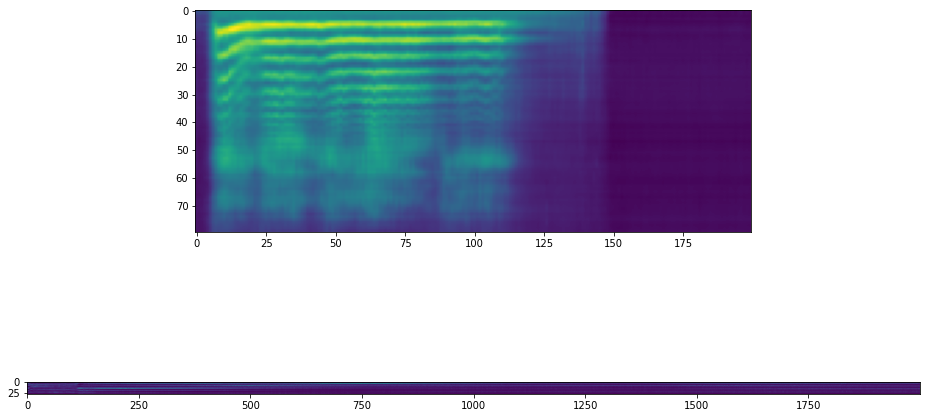

In [111]:
text = "ni3 hao3 wo3 shi4 hu2 bing3 cheng2"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, attention = model.infer(processed, lengths)



fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[:,:,:200][0].cpu().detach())
ax2.imshow(attention[0].cpu().detach().transpose(0,1))

In [110]:
spec[:,:,:200]

torch.Size([1, 80, 2000])

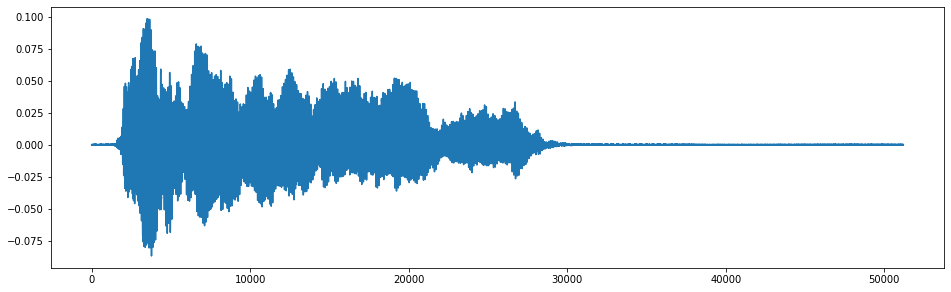

In [112]:
with torch.no_grad():
    waveforms = waveglow.infer(spec[:,:,:200])

# fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
# ax1.imshow(spec[0].cpu().detach())
plt.plot(waveforms[0].cpu().detach())

torchaudio.save("_assets/my_output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)